In [1]:
import cupy as np

def cov_matern(d, loghyper, x):
    ell = np.exp(loghyper[0])
    sf2 = np.exp(2 * loghyper[1])    
    def f(t):
        if d == 1: return 1
        if d == 3: return 1 + t
        if d == 5: return 1 + t * (1 + t / 3)
        if d == 7: return 1 + t * (1 + t * (6 + t) / 15)       
    def m(t):
        return f(t) * np.exp(-t)   
    dist_sq = ((x[:, None] - x[None, :]) / ell) ** 2
    return sf2 * m(np.sqrt(d * dist_sq))

def bohman(loghyper, x):
    range_ = np.exp(loghyper[0])
    dis = np.abs(x[:, None] - x[None, :])
    r = np.minimum(dis / range_, 1)
    k = (1 - r) * np.cos(np.pi * r) + np.sin(np.pi * r) / np.pi
    k[k < 1e-16] = 0
    k[np.isnan(k)] = 0
    return k

def unfold(tensor, mode):
    return np.reshape(np.moveaxis(tensor, mode, 0), (tensor.shape[mode], -1), order = 'F')

def fold(mat, dim, mode):
    index = list()
    index.append(mode)
    for i in range(dim.shape[0]):
        if i != mode:
            index.append(i)
    return np.moveaxis(np.reshape(mat, list(dim[index]), order = 'F'), 0, mode)

def kroneckerMVM(K3, K2, K1, vec, d1, d2, d3):
    temp1 = (K1 @ vec.reshape(d1, d2, d3, order = 'F').reshape(d1, -1)).reshape(d1, d2, d3)
    temp2 = (K2 @ temp1.transpose(1, 0, 2).reshape(d2, -1)).reshape(d2, d1, d3).transpose(1, 0, 2)
    temp3 = (K3 @ temp2.transpose(2, 0, 1).reshape(d3, -1)).reshape(d3, d1, d2).transpose(1, 2, 0)
    return temp3.ravel(order = 'F')

def Ap_operatorT(vec, maskT, KrU, KrU_T, Qu, rho, R, M):
    X = vec.reshape(R, M, order = 'F') 
    temp = KrU @ X      
    temp *= maskT  
    Ap1 = KrU_T @ temp
    Ap2 = rho * (X @ Qu)
    return (Ap1 + Ap2).ravel(order = 'F')

def cg_factorT(Qu, rho, KrU, mask_matrixT, YR_tilde, priorvalue, max_iter):
    R, M = YR_tilde.shape   
    Y_flat = YR_tilde.ravel(order = 'F')    
    x = priorvalue.copy()
    KrU_T = KrU.T   
    Ax = Ap_operatorT(x, mask_matrixT, KrU, KrU_T, Qu, rho, R, M)
    r = Y_flat - Ax
    p = r.copy()
    rsold = np.dot(r, r)
    approxE = np.zeros(max_iter)    
    for i in range(max_iter):
        Ap = Ap_operatorT(p, mask_matrixT, KrU, KrU_T, Qu, rho, R, M)
        alpha = rsold / np.dot(p, Ap)
        x += alpha * p
        r -= alpha * Ap
        rsnew = np.dot(r, r)
        approxE[i] = np.sqrt(rsnew)
        if (i + 1) % 10 == 0 or i == max_iter - 1:
            if rsnew < 1e-8:
                break
        p = r + (rsnew / rsold) * p
        rsold = rsnew       
    return x, approxE


In [2]:
from cupy.fft import fft, ifft

def embed_to_circulant(col, fft_len):
    c = np.concatenate([col, np.array([0]), col[:0:-1]])
    return np.pad(c, (0, fft_len - len(c)))

def toeplitz_fft_mv_batch(c_fft, X):
    # X shape: (n, m)
    n, m = X.shape
    fft_len = 2*n
    X_padded = np.pad(X, ((0, fft_len - n), (0,0)))
    X_fft = fft(X_padded, axis=0)
    result = ifft(c_fft * X_fft, axis=0).real[:n, :]
    return result


def kroneckerMVM(K3, K2, K1, vec, d1, d2, d3):
    temp1 = (K1 @ vec.reshape(d1, d2, d3, order = 'F').reshape(d1, -1)).reshape(d1, d2, d3)
    temp2 = (K2 @ temp1.transpose(1, 0, 2).reshape(d2, -1)).reshape(d2, d1, d3).transpose(1, 0, 2)
    temp3 = (K3 @ temp2.transpose(2, 0, 1).reshape(d3, -1)).reshape(d3, d1, d2).transpose(1, 2, 0)
    return temp3.ravel(order = 'F')
    

def kronecker_fft_vectorized(K3, cfft2, cfft1, vec, d1, d2, d3):
    
    X = vec.reshape((d1, d2, d3), order='F')

    # Mode-1 (rows), process (d1, d2*d3)
    X = X.reshape(d1, -1)
    X = toeplitz_fft_mv_batch(cfft1, X)
    X = X.reshape(d1, d2, d3)
    
    # Mode-2 (columns), process (d2, d1*d3)
    X = np.transpose(X, (1, 0, 2)).reshape(d2, -1)
    X = toeplitz_fft_mv_batch(cfft2, X)
    X = X.reshape(d2, d1, d3).transpose(1, 0, 2)
    
    # Mode-3 (channels)
    X = np.tensordot(X, K3, axes=([2],[0]))
    return X.ravel(order = 'F')


def Ap_operatorL(vec, pos_obs, Kd, cfftt, cffts, gamma, d1, d2, d3):
    x = np.zeros(d1 * d2 * d3)
    x[pos_obs] = vec
    Ap1 = kronecker_fft_vectorized(Kd, cfftt, cffts, x, d1, d2, d3)
    return Ap1[pos_obs] + gamma * vec


def cg_local(gamma, Kd, cfftt, cffts, pos_obs, YR_tilde, priorvalue, max_iter):
    d1, d2, d3  = YR_tilde.shape
    Y_obs = (YR_tilde.ravel(order = 'F'))[pos_obs]
    x = priorvalue.copy()
    Ax = Ap_operatorL(x, pos_obs, Kd, cfftt, cffts, gamma, d1, d2, d3)
    r = Y_obs - Ax
    p = r.copy()
    rsold = np.dot(r, r)
    approxE = np.zeros(max_iter)
    for i in range(max_iter):
        Ap = Ap_operatorL(p, pos_obs, Kd, cfftt, cffts, gamma, d1, d2, d3)
        alpha = rsold / np.dot(p, Ap)
        x += alpha * p
        r -= alpha * Ap
        rsnew = np.dot(r, r)
        approxE[i] = np.sqrt(rsnew)
        if (i + 1) % 10 == 0 or i == max_iter - 1:
            if rsnew < 1e-8:
                break       
        p = r + (rsnew / rsold) * p
        rsold = rsnew
    return x, approxE


d1, d2, d3 = 256, 256, 3
np.random.seed(42)
vec = np.random.randn(d1 * d2 * d3)

grid = np.arange(d1)
grid = grid[:,None]
ell = 10.0
K1 = np.exp(-(grid - grid.T)**2 / (2*ell**2))
K2 = K1.copy()
K3 = np.array([[1.0, 0.5, 0.2],
               [0.5, 1.0, 0.3],
               [0.2, 0.3, 1.0]])



c_fft1 = fft(embed_to_circulant(K1[:,0], 2*K1.shape[0]))[:, None] 
c_fft2 = fft(embed_to_circulant(K2[:,0], 2*K2.shape[0]))[:, None] 

a1 = kroneckerMVM(K3, K2, K1, vec, d1, d2, d3)
a2 = kronecker_fft_vectorized(K3, c_fft2, c_fft1, vec, d1, d2, d3)

print(np.sum(np.abs(a1-a2)))

2.1495048875596126e-09


In [3]:
#from scipy.linalg import inv, khatri_rao

from cupyx.scipy.linalg import khatri_rao
import numpy

def GLSKF(I, Omega, lengthscaleU: list, lengthscaleR: list, varianceU: list, varianceR: list, tapering_range, d_MaternU, d_MaternR, R, rho, gamma, maxiter, K0, epsilon):
    N = I.shape
    N = numpy.array(N)
    
    D = I.ndim
    maxP = float(np.max(I))

    Omega = Omega.astype(bool)
    pos_miss = np.where(Omega == 0)
    num_obser = np.sum(Omega)
    mask_matrix = [unfold(Omega, d) for d in range(D)]
    idx = np.sum(mask_matrix[2], axis = 0) > 0
    train_matrix = I * Omega
    train_matrix = train_matrix[train_matrix > 0]
    Isubmean = I - np.mean(train_matrix)
    T = Isubmean * Omega
    mask_matrixT = [mask_matrix[d].T for d in range(D)]
    mask_flat = [mask_matrix[d].ravel(order = 'F') for d in range(D)]
    pos_obs = [np.where(mask_flat[d] == 1) for d in range(D)]

    hyper_Ku = [None] * D
    hyper_Ku[0] = [np.log(lengthscaleU[0]), np.log(varianceU[0])]
    hyper_Ku[1] = [np.log(lengthscaleU[1]), np.log(varianceU[1])]   
    hyper_Kr = [None] * D
    hyper_Kr[0] = [np.log(lengthscaleR[0]), np.log(varianceR[0]), np.log(tapering_range)]
    hyper_Kr[1] = [np.log(lengthscaleR[1]), np.log(varianceR[1]), np.log(tapering_range)]

    Ku, Kr = [None] * D, [None] * D
    invKu = [None] * D

    x = np.arange(1, N[0] + 1)
    Ku[0] = cov_matern(d_MaternU, hyper_Ku[0], x)
    invKu[0] = np.linalg.inv(Ku[0])
    TaperM = bohman([hyper_Kr[0][2]], x)
    Kr[0] = cov_matern(d_MaternR, hyper_Kr[0][:2], x) * TaperM

    x = np.arange(1, N[1] + 1)
    Ku[1] = cov_matern(d_MaternU, hyper_Ku[1], x)
    invKu[1] = np.linalg.inv(Ku[1])
    TaperM = bohman([hyper_Kr[1][2]], x)
    Kr[1] = cov_matern(d_MaternR, hyper_Kr[1][:2], x)  * TaperM

    invKu[2] = np.eye(N[2])
    Kr[2] = np.eye(N[2])
    

    X = T
    X[pos_miss] = T.sum() / num_obser
    U = [0.1 * np.random.randn(N[d], R) for d in range(D)]
    M_unfold1 = U[0] @ khatri_rao(U[2], U[1]).T
    M = fold(M_unfold1, N, 0)
    Uvector = [U[d].ravel(order = 'F') for d in range(D)]
    UTvector = [U[d].T.ravel(order = 'F') for d in range(D)]
    Rtensor = np.zeros(N)
    Rvector = Rtensor.ravel(order = 'F')   
    Rvector_temp = Rtensor.ravel(order = 'F')
    X[pos_miss] = M[pos_miss] + Rtensor[pos_miss]

    d_all = np.arange(0, D)
    train_norm = np.linalg.norm(T)
    last_ten = T.copy()
    psnrf = np.zeros(maxiter)
    approxU = [None] * D
    iter = 0
    
    cfft_0 = fft(embed_to_circulant(Kr[0][:,0], 2*Kr[0].shape[0]))[:, None] 
    cfft_1 = fft(embed_to_circulant(Kr[1][:,0], 2*Kr[1].shape[0]))[:, None] 
    
    while True:
        Gtensor = X - Rtensor
        Gtensor_mask = Gtensor * Omega
        for d in range(D):
            dsub = np.delete(d_all, d)
            dsub = numpy.array(dsub.get())
            KrU = khatri_rao(U[dsub[1]], U[dsub[0]])          
            HG = KrU.T @ unfold(Gtensor_mask, d).T
            UTvector[d], approxU[d] = cg_factorT(invKu[d], rho, KrU, mask_matrixT[d], HG, UTvector[d], 100)           
            U[d] = (UTvector[d].reshape(R, N[d], order = 'F')).T          
        M_unfold1 = U[0] @ (khatri_rao(U[2], U[1]).T)
        M = fold(M_unfold1, N, 0)
        X[pos_miss] = M[pos_miss] + Rtensor[pos_miss]
        if iter >= K0:
            Ltensor = X - M
            Ltensor_mask = Ltensor * Omega
            Rvector_temp[pos_obs[0]], approxE = cg_local(gamma, Kr[2], cfft_1, cfft_0, pos_obs[0], \
                                                         Ltensor_mask, Rvector_temp[pos_obs[0]], 100)
            
            #Rvector = kroneckerMVM(Kr[2], Kr[1], Kr[0], Rvector_temp, N[0], N[1], N[2])
            Rvector = kronecker_fft_vectorized(Kr[2], cfft_1, cfft_0, Rvector_temp, N[0], N[1], N[2])
            Rtensor = Rvector.reshape(N, order = 'F')
            Rtensor_unfold3 = unfold(Rtensor, 2)
            Rtensor_unfold3_obs = Rtensor_unfold3[:, idx]
            Kr[2] = np.cov(Rtensor_unfold3_obs)          
        else:
            Rtensor = np.zeros_like(Rtensor)    
        X[pos_miss] = M[pos_miss] + Rtensor[pos_miss]
        Xori = X + np.mean(train_matrix)
        Xrecovery = np.maximum(0, Xori)
        Xrecovery = np.minimum(maxP, Xrecovery)
        mseC1 = np.linalg.norm(I[:, :, 0].astype(float) - Xrecovery[:, :, 0], 'fro') ** 2 / (N[0] * N[1])
        psnrC1 = 10 * np.log10(maxP**2 / mseC1)
        mseC2 = np.linalg.norm(I[:, :, 1].astype(float) - Xrecovery[:, :, 1], 'fro') ** 2 / (N[0] * N[1])
        psnrC2 = 10 * np.log10(maxP**2 / mseC2)
        mseC3 = np.linalg.norm(I[:, :, 2].astype(float) - Xrecovery[:, :, 2], 'fro') ** 2 / (N[0] * N[1])
        psnrC3 = 10 * np.log10(maxP**2 / mseC3)
        psnrf[iter] = (psnrC1 + psnrC2 + psnrC3)/3
        iter += 1
        print(f"Epoch = {iter}, PSNR = {psnrf[iter-1]}")
        tol = np.linalg.norm((X - last_ten)) / train_norm
        last_ten = X.copy()
        if (tol < epsilon) or (iter >= maxiter):
            break
    return Xori, Rtensor + np.mean(train_matrix), M + np.mean(train_matrix)

In [4]:
from PIL import Image
import scipy.io
seedr = 6
np.random.seed(seedr)
I = np.array(Image.open('./data/original/airplane.tiff'))
Omega = scipy.io.loadmat('./data/mask/airplane_90RM.mat')['Omega']

Omega = np.array(Omega)
lengthscaleU = np.ones(2) * 30
varianceU = np.ones(2)
lengthscaleR = np.ones(2) * 5
varianceR = np.ones(2)
tapering_range = 20
d_MaternU, d_MaternR = 3, 3
R = 20
rho, gamma = 20, 5
maxiter, K0 = 100, 60
epsilon = 1e-4
X, Rtensor, Mtensor = GLSKF(I, Omega, lengthscaleU, lengthscaleR, varianceU, varianceR, tapering_range, d_MaternU, d_MaternR, R, rho, gamma, maxiter, K0, epsilon)

Epoch = 1, PSNR = 15.256277296017322
Epoch = 2, PSNR = 19.313386429488173
Epoch = 3, PSNR = 21.733939931032484
Epoch = 4, PSNR = 22.310465028892335
Epoch = 5, PSNR = 22.50310709915064
Epoch = 6, PSNR = 22.622030298967115
Epoch = 7, PSNR = 22.710333808305165
Epoch = 8, PSNR = 22.774995835136938
Epoch = 9, PSNR = 22.821746189747483
Epoch = 10, PSNR = 22.856873462148886
Epoch = 11, PSNR = 22.884955800403432
Epoch = 12, PSNR = 22.908450293269038
Epoch = 13, PSNR = 22.928718708394186
Epoch = 14, PSNR = 22.94671796646145
Epoch = 15, PSNR = 22.96298634632559
Epoch = 16, PSNR = 22.977785073138577
Epoch = 17, PSNR = 22.991386742552084
Epoch = 18, PSNR = 23.003954807637
Epoch = 19, PSNR = 23.015701451910786
Epoch = 20, PSNR = 23.02675515778451
Epoch = 21, PSNR = 23.037266776439868
Epoch = 22, PSNR = 23.04731279295996
Epoch = 23, PSNR = 23.05686817902875
Epoch = 24, PSNR = 23.065919412939266
Epoch = 25, PSNR = 23.07442853856112
Epoch = 26, PSNR = 23.082489518276063
Epoch = 27, PSNR = 23.090141612

In [5]:
%load_ext line_profiler
maxiter, K0 = 4, 1

%lprun -f cg_local GLSKF(I, Omega, lengthscaleU, lengthscaleR, varianceU, varianceR, tapering_range, d_MaternU, d_MaternR, R, rho, gamma, maxiter, K0, epsilon)

Epoch = 1, PSNR = 15.255557053629056
Epoch = 2, PSNR = 22.325619765597406
Epoch = 3, PSNR = 26.780712785184477
Epoch = 4, PSNR = 26.999491573924995


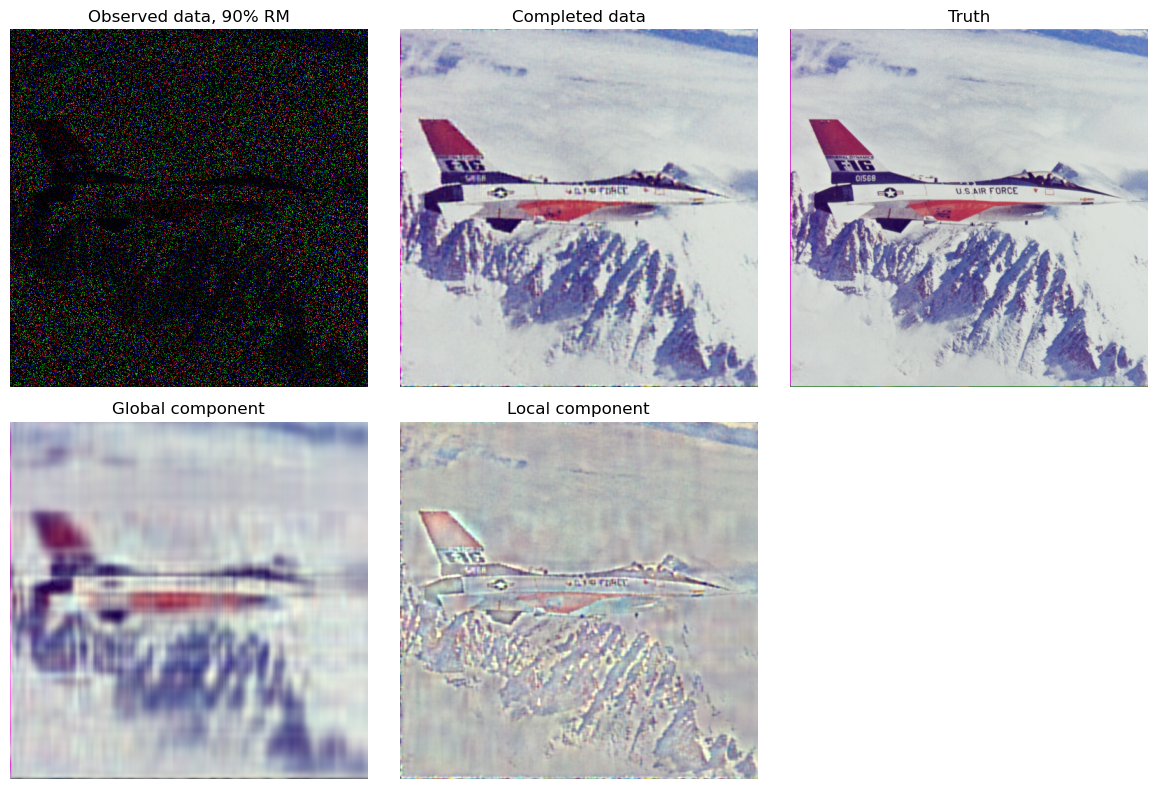

In [6]:
import matplotlib.pyplot as plt
import numpy as np

I = np.array(Image.open('./data/original/airplane.tiff'))
Omega = scipy.io.loadmat('./data/mask/airplane_90RM.mat')['Omega']

fig, axes = plt.subplots(2, 3, figsize=(12, 8))
fig.set_tight_layout(True)

# Top-left subplot
axes[0, 0].imshow(np.uint8(np.minimum(255, np.abs(I * Omega))))
axes[0, 0].set_title('Observed data, 90% RM')
axes[0, 0].axis("off")

axes[0, 1].imshow(np.uint8(np.minimum(255, np.abs(X.get()))))
axes[0, 1].set_title('Completed data')
axes[0, 1].axis("off")

axes[1, 0].imshow(np.uint8(np.minimum(255, np.abs(Mtensor.get()))))
axes[1, 0].set_title('Global component')
axes[1, 0].axis("off")

axes[1, 1].imshow(np.uint8(np.minimum(255, np.abs(Rtensor.get()))))
axes[1, 1].set_title('Local component')
axes[1, 1].axis("off")

axes[0, 2].imshow(np.uint8(np.minimum(255, I)))
axes[0, 2].set_title('Truth')
axes[0, 2].axis("off")


axes[1, 2].axis("off")


fig.savefig('Result.pdf')